In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [20]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats
    
model_path = './cifar_model.pth'

In [12]:
def train(net, trainloader, optim, epoch, device):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip, ground_truth = ip.to(device), ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 200 == 0:    # print at the interval of mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

In [4]:
def test(net, testloader, device):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            im, ground_truth = im.to(device), ground_truth.to(device)
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

In [17]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


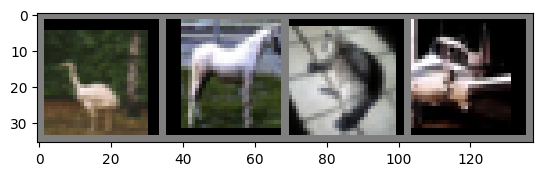

    bird  ||  horse  ||  cat  ||  plane


In [15]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [23]:
# create net
device = torch.device("cpu")
lenet = LeNet()
lenet.to(device)

# define optimizer
torch.use_deterministic_algorithms(False)
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):
    start_time = time.time()  
    train(lenet, trainloader, optim, epoch, device)
    end_time = time.time()
    print('Epoch %d took %.2f seconds' % (epoch + 1, end_time - start_time))
    test(lenet, testloader, device)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.011
Epoch 1 took 11.52 seconds
LeNet accuracy on 10000 images from test dataset: 48 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.487
Epoch 2 took 11.54 seconds
LeNet accuracy on 10000 images from test dataset: 52 %

[Epoch number : 3, Mini-batches:  1000] loss: 7.001
Epoch 3 took 11.53 seconds
LeNet accuracy on 10000 images from test dataset: 54 %

[Epoch number : 4, Mini-batches:  1000] loss: 6.591
Epoch 4 took 11.47 seconds
LeNet accuracy on 10000 images from test dataset: 57 %

[Epoch number : 5, Mini-batches:  1000] loss: 6.304
Epoch 5 took 11.59 seconds
LeNet accuracy on 10000 images from test dataset: 58 %

[Epoch number : 6, Mini-batches:  1000] loss: 6.082
Epoch 6 took 11.64 seconds
LeNet accuracy on 10000 images from test dataset: 59 %

[Epoch number : 7, Mini-batches:  1000] loss: 5.952
Epoch 7 took 11.63 seconds
LeNet accuracy on 10000 images from test dataset: 58 %

[Epoch number : 8, Mini-batches:  1000] loss: 5.834
Epo

In [24]:
torch.save(lenet.state_dict(), model_path)

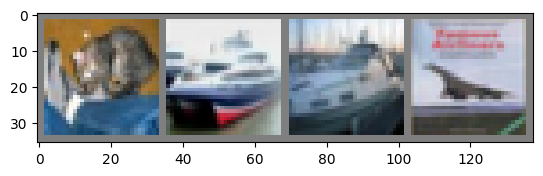

Label:         cat  ship  ship plane


C:\Users\jrbir\AppData\Local\Temp\ipykernel_16148\18595654.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_cached.load_state_dict(torch.load(model_path))


Prediction:    cat  ship  ship plane


In [26]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [27]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 69 %


In [28]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 78 %
Model accuracy for class   car : 86 %
Model accuracy for class  bird : 61 %
Model accuracy for class   cat : 49 %
Model accuracy for class  deer : 64 %
Model accuracy for class   dog : 59 %
Model accuracy for class  frog : 72 %
Model accuracy for class horse : 68 %
Model accuracy for class  ship : 79 %
Model accuracy for class truck : 74 %
